# Creating Driver

In [1]:
from pynq import DefaultHierarchy
from pynq import allocate
from math import log
import numpy as np

class FFT_Block_Driver(DefaultHierarchy):
    def __init__(self, description):
        super().__init__(description)
        self.configuration = 0
        self.fft_size = 0
        
    def _get_config_data(self, fft_direction, size):
        fft_direction.zfill(8)
        byte2 = '0'*8 #Cyclic Prefix
        x = int(log(size,2))
        fft_size = bin(x)[2:]
        fft_size.zfill(8)
        config_data = fft_direction + byte2 + fft_size
        return int(config_data,2)
    
    def configure(self, fft_direction, size):
        self.configuration = self._get_config_data(fft_direction, size)
        config_data = allocate(1, np.uint32)
        config_data[0] = self.configuration
        self.config_dma.sendchannel.transfer(config_data)
        self.config_dma.sendchannel.wait()
        del config_data
    
    def stream(self, input_buffer):
        output_buffer = allocate(SAMPLES, np.csingle)
        self.data_dma.sendchannel.transfer(input_buffer)
        self.data_dma.recvchannel.transfer(output_buffer)
        self.data_dma.sendchannel.wait()
        self.data_dma.recvchannel.wait()
        return output_buffer
    
    @staticmethod
    def checkhierarchy(description):
        if 'data_dma' in description['ip'] \
            and 'config_dma' in description['ip']:
                return True
        return False


In [2]:
from pynq import Overlay
overlay = Overlay("FFT_Reconfig.bit")

In [3]:
overlay?

In [4]:
fft = overlay.fft_block

In [5]:
fft?

# Testing The Driver

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

def get_random_data(SAMPLES, time_interval):
    A1 = random.uniform(100,1000)
    A2 = random.uniform(100,1000)
    A3 = random.uniform(100,1000)
    f1 = random.uniform(100,180)
    f2 = random.uniform(200,480)
    f3 = random.uniform(500,1500)
    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2
    w3 = 2*np.pi*f3
    t = np.linspace(0, time_interval, SAMPLES)
    data = A1*np.sin(w1*t,dtype=np.csingle) + A2*np.sin(w2*t,dtype=np.csingle) + A3*np.sin(w3*t,dtype=np.csingle)
    return (data,t)

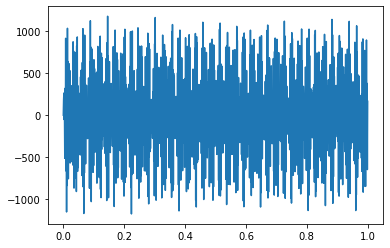

In [7]:
SAMPLES = 1024
time_interval = 1
data,t = get_random_data(SAMPLES, time_interval)
plt.plot(t, np.real(data))

In [17]:
%%time
sw_fft = np.fft.fft(data)

CPU times: user 4.83 ms, sys: 260 µs, total: 5.09 ms
Wall time: 3.56 ms


In [15]:
input_buffer = allocate(SAMPLES, np.csingle)
np.copyto(input_buffer, data)

In [10]:
fft.configure('1', SAMPLES)

In [11]:
%%time
output = fft.stream(input_buffer)

CPU times: user 6.05 ms, sys: 0 ns, total: 6.05 ms
Wall time: 5.8 ms


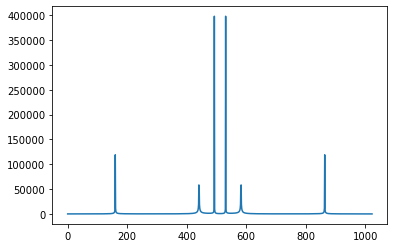

In [12]:
plt.plot(np.abs(output))

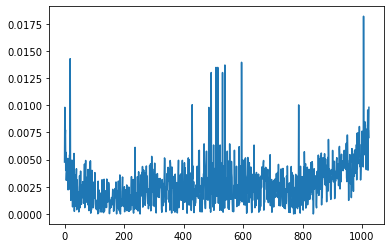

In [13]:
plt.plot(np.abs(np.real(sw_fft)-np.real(output)))